In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 

In [2]:
class FeatureExtractor:
    def __init__(self):
        base_model = VGG16(weights='imagenet')
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

    def extract(self, img):
        img = img.resize((224, 224))
        img = img.convert('RGB')
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [ ]:
for img_path in sorted(Path("./static/img").glob("*.jpg")):
    print(img_path)
    feature = fe.extract(img=Image.open(img_path))
    feature_path = Path("./static/feature") / (img_path.stem + '.npy')
    np.save(feature_path, feature)

In [5]:
fe = FeatureExtractor()
features = []
img_paths = []
for feature_path in Path("./static/feature").glob("*.npy"):
    features.append(np.load(feature_path))
    img_paths.append(Path("./static/img") / (feature_path.stem + ".jpg"))
features = np.array(features)

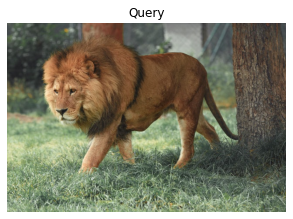

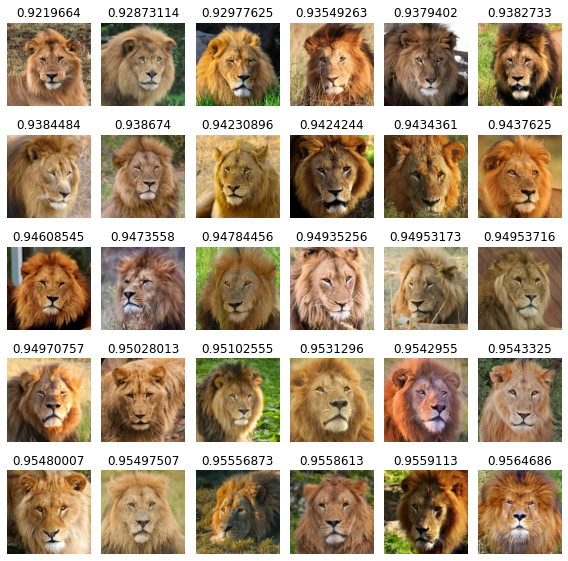

In [8]:
# Insert the image query
img = Image.open("./static/query/2.jpg")

# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], img_paths[id]) for id in ids]

# Visualize the query
fig = plt.figure(figsize=(5,5))
plt.axis('off')
plt.title('Query')
plt.imshow(img)
plt.show()

# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))

for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
    
fig.tight_layout()
plt.show()

In [22]:
feat_id = [i.stem for i in Path("./static/feature").glob("*.npy")]
feat_id[:5]

['0', '1', '10', '100', '1000']

In [24]:
import pandas as pd
df = pd.DataFrame(features)
feat_id = [i.stem for i in Path("./static/feature").glob("*.npy")]
df['id'] = feat_id
df

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,id
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.038583,0.000000,0.000000,0.0,0
1,0.0,0.0,0.0,0.000000,0.0,0.047405,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.010464,0.000000,0.065461,0.0,1
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.058726,0.020252,0.000000,0.0,10
3,0.0,0.0,0.0,0.001450,0.0,0.013940,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,100
4,0.0,0.0,0.0,0.023073,0.0,0.012921,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.062598,0.014126,0.000000,0.0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733,0.0,0.0,0.0,0.000000,0.0,0.020091,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000698,0.000000,0.018149,0.000000,0.0,995
4734,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.031736,0.000000,0.040466,0.0,996
4735,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.045700,0.000000,0.015603,0.0,997
4736,0.0,0.0,0.0,0.000000,0.0,0.002760,0.000262,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,998


[2, 3, 4, 5, 6, 7, 8, 9, 10]

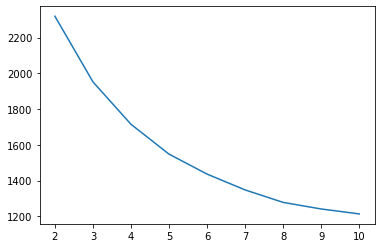

In [30]:
from sklearn.cluster import KMeans

X = df.iloc[:, 0:-1].values

clusters = [i for i in range(2, 11)]
inertia = []
for i in clusters:
    model = KMeans(n_clusters=i, random_state=42)
    model.fit(X)
    inertia.append(model.inertia_)
plt.plot(clusters, inertia)
plt.show()

In [31]:
model = KMeans(n_clusters=8)
model.fit(X)
label = model.labels_
label

array([2, 7, 4, ..., 2, 5, 1])

In [33]:
df['label'] = label
df

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,id,label
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.038583,0.000000,0.000000,0.0,0,2
1,0.0,0.0,0.0,0.000000,0.0,0.047405,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.010464,0.000000,0.065461,0.0,1,7
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.058726,0.020252,0.000000,0.0,10,4
3,0.0,0.0,0.0,0.001450,0.0,0.013940,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,100,5
4,0.0,0.0,0.0,0.023073,0.0,0.012921,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.062598,0.014126,0.000000,0.0,1000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4733,0.0,0.0,0.0,0.000000,0.0,0.020091,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000698,0.000000,0.018149,0.000000,0.0,995,1
4734,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.031736,0.000000,0.040466,0.0,996,2
4735,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.045700,0.000000,0.015603,0.0,997,2
4736,0.0,0.0,0.0,0.000000,0.0,0.002760,0.000262,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,998,5


In [34]:
df.label.values

array([2, 7, 4, ..., 2, 5, 1])

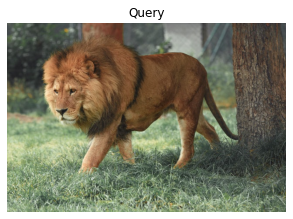

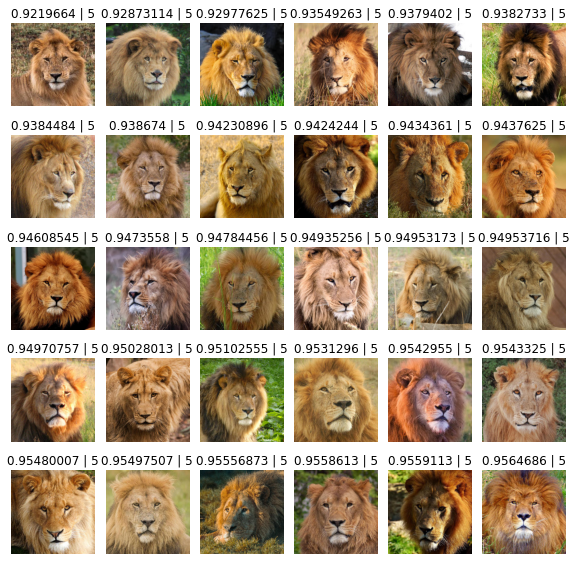

In [35]:
# Insert the image query
img = Image.open("./static/query/2.jpg")

# Extract its features
query = fe.extract(img)

# Calculate the similarity (distance) between images
dists = np.linalg.norm(features - query, axis=1)

# Extract 30 images that have lowest distance
ids = np.argsort(dists)[:30]
scores = [(dists[id], img_paths[id], label[id]) for id in ids]

# Visualize the query
fig = plt.figure(figsize=(5,5))
plt.axis('off')
plt.title('Query')
plt.imshow(img)
plt.show()

# Visualize the result
axes=[]
fig=plt.figure(figsize=(8,8))

for a in range(5*6):
    score = scores[a]
    axes.append(fig.add_subplot(5, 6, a+1))
    subplot_title=str(score[0]) + ' | ' + str(score[2])
    axes[-1].set_title(subplot_title)  
    plt.axis('off')
    plt.imshow(Image.open(score[1]))
    
fig.tight_layout()
plt.show()